In [179]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from tqdm import tqdm

In [180]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

In [181]:
param_name = "Theta_2"

with open(f'/home/chri6578/Documents/CES/params/{param_name}.pickle', 'rb') as file:
    Theta = pickle.load(file)
    
n = Theta['n']
Lambda = Theta['Lambda']
Eta = Theta['Eta']
Alpha = Theta['Alpha']
Beta = Theta['Beta']
Gamma = Theta['Gamma']
T = 1e5

In [182]:
# step 2
PHI = {}

for i in range(n):
    PHI[i] = []
    t = 0
    t_prev = 0
    while t_prev < T:
        t = np.random.exponential(Lambda[i])[0]
        PHI[i].append(t + t_prev)
        t_prev = t + t_prev

In [183]:
# step 3
tuple_list = [(i, t) for i in range(n) for t in PHI[i]]
T_list = sorted(tuple_list, key=lambda x: x[1])

In [184]:
# steps 4-11

E_all = {}
for i in range(n):
    E_all[i] = []
t_last = np.zeros((n,))

for (e,t) in T_list:
    # update x_i^t
    s = np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) ) + Eta[e]
    p = sigmoid(s)
    # print(s, p)
    trial = np.random.binomial(1,p)
    if trial:
        E_all[e].append(t)
        t_last[e] = t

In [185]:
# save PHI, and E_all

# load Theta, PHI, and E_all

In [211]:
# Causal Discovery (full data)

tau_bar = 500

Cp = np.zeros((n,n))
Cm = np.zeros((n,n))
C = np.zeros((n,n))

for i in tqdm(range(n)):
    for j in range(n):
        n_yz = 0
        n_yz_ = 0
        n_y_z = 0
        n_y_z_ = 0
        for t in PHI[i]:
            # search for j in (t -tau_bar, t)
            Lij = [t_ for t_ in E_all[j] if t - tau_bar < t_ <= t]
            if len(Lij) > 0:
                if t in E_all[i]:
                    # (y_i, z_j)
                    n_yz += 1
                else:
                    # (y_i', z_j)
                    n_y_z += 1
            
            else:
                if t not in E_all[i]:
                    # (y_i', z_j')
                    n_y_z_ += 1
                
                else:
                    # (y_i, z_j')
                    n_yz_ += 1
                    
        # Calculate probabilities here
        
        P_yz, P_yz_, P_y_z, P_y_z_ = 0, 0, 0, 0
        
        if n_yz + n_y_z > 0:
            P_yz = n_yz/(n_yz + n_y_z)
            
        if n_yz_ + n_y_z_ > 0:
            P_yz_ = n_yz_/(n_yz_ + n_y_z_)
        
        if n_yz + n_y_z > 0:
            P_y_z = n_y_z/(n_yz + n_y_z)
        
        if n_yz_ + n_y_z_ > 0:
            P_y_z_ = n_y_z_/(n_yz_ + n_y_z_)
        
        Cp[i][j] = P_yz - P_yz_ 
        Cm[i][j] = P_y_z - P_y_z_ 
        
        C[i][j] = ( (n_yz + n_yz_)*Cp[i][j] + (n_y_z + n_y_z_)*Cm[i][j] )/(n_yz + n_yz_ + n_y_z + n_y_z_)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 15.85it/s]


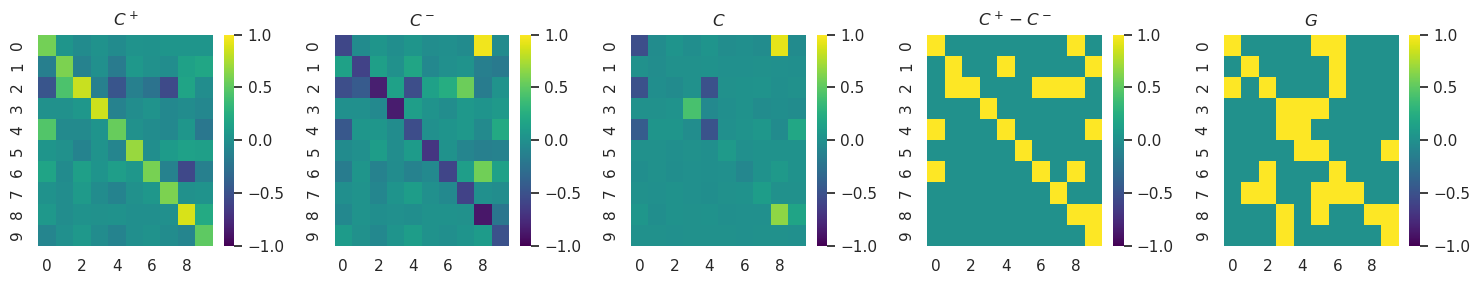

In [212]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Plot each heatmap
sns.heatmap(Cp, ax=axes[0], cmap="viridis", vmin=-1, vmax=1)
axes[0].set_title("$ C^+ $")

sns.heatmap(Cm, ax=axes[1], cmap="viridis", vmin=-1, vmax=1)
axes[1].set_title("$ C^- $")

sns.heatmap( C, ax=axes[2], cmap="viridis", vmin=-1, vmax=1)
axes[2].set_title("$ C $")

sns.heatmap( np.abs(Cp - Cm) > 0.3 , ax=axes[3], cmap="viridis", vmin=-1, vmax=1)
axes[3].set_title("$ C^+ - C^- $")

sns.heatmap(Alpha>0, ax=axes[4], cmap="viridis", vmin=-1, vmax=1)
axes[4].set_title("$ G $")

# Adjust layout
plt.tight_layout()
plt.show()

In [188]:
G = np.double(Alpha > 0)

In [191]:
np.linalg.norm(G - Cp)/n, np.linalg.norm(G - Cm)/n, np.linalg.norm(G - Cp + Cm)/n, np.linalg.norm(G - C)/n

(0.47997265859357635,
 0.7169997295930306,
 0.5247179421819724,
 0.5699898369664428)

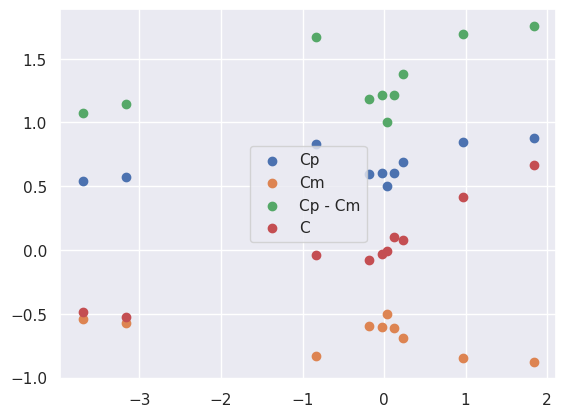

In [217]:
plt.scatter(Eta, [Cp[i][i] for i in range(n)], label='Cp')
plt.scatter(Eta, [Cm[i][i] for i in range(n)], label='Cm')
plt.scatter(Eta, [Cp[i][i] - Cm[i][i] for i in range(n)], label='Cp - Cm')
plt.scatter(Eta, [C[i][i] for i in range(n)], label='C')
plt.legend()

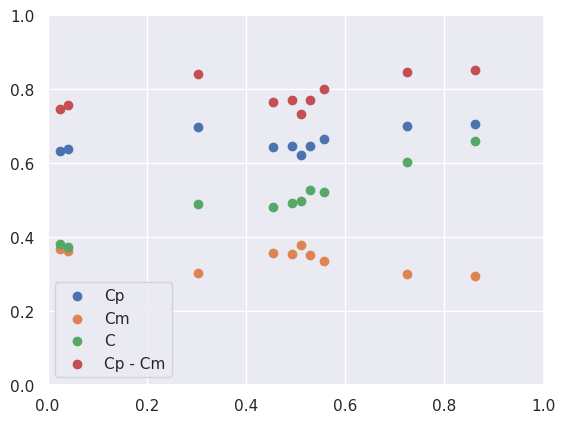

In [ ]:
plt.scatter(sigmoid(Eta), sigmoid(np.array([Cp[i][i] for i in range(n)])), label='Cp')
plt.scatter(sigmoid(Eta), sigmoid(np.array([Cm[i][i] for i in range(n)])), label='Cm')
plt.scatter(sigmoid(Eta), sigmoid(np.array([C[i][i] for i in range(n)])), label='C') # explains it best
plt.scatter(sigmoid(Eta), sigmoid(np.array([Cp[i][i] - Cm[i][i] for i in range(n)])), label='Cp - Cm')
plt.ylim([0,1])
plt.xlim([0,1])
plt.legend()